In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [2]:
# Load the .npy file
data = np.load('Images.npy',allow_pickle=True)

In [3]:
data.shape

(393, 2)

In [4]:
im_height = 128
im_width = 128
ALPHA = 1
im_size = 128

In [5]:
y = np.zeros((int(data.shape[0]), im_height, im_width))
X = np.zeros((int(data.shape[0]), im_height, im_width, 3))
for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize = (im_height, im_width), interpolation = cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype = np.float32))
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * im_height)
    x2 = int(i['points'][1]['x'] * im_width)
    y1 = int(i['points'][0]['y'] * im_height)
    y2 = int(i['points'][1]['y'] * im_width)
    y[index][y1:y2, x1:x2] = 1

In [6]:
X.shape

(393, 128, 128, 3)

In [7]:
y.shape

(393, 128, 128)

In [8]:
train_vals = slice(0, 400)

# Not creating test set as we don't have enough data for test set

X_train = X[train_vals]
Y_train = y[train_vals]

print("Values in X_train data:", X_train.shape)
print("Values in y_train data:", Y_train.shape)

Values in X_train data: (393, 128, 128, 3)
Values in y_train data: (393, 128, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


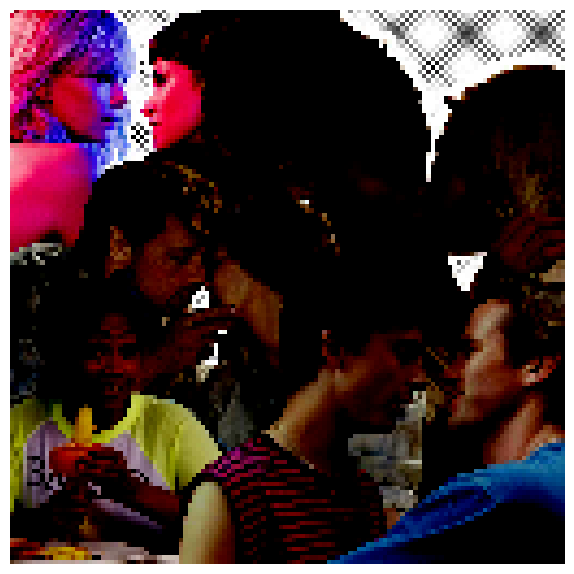

In [9]:
n = 32
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X_train[n])

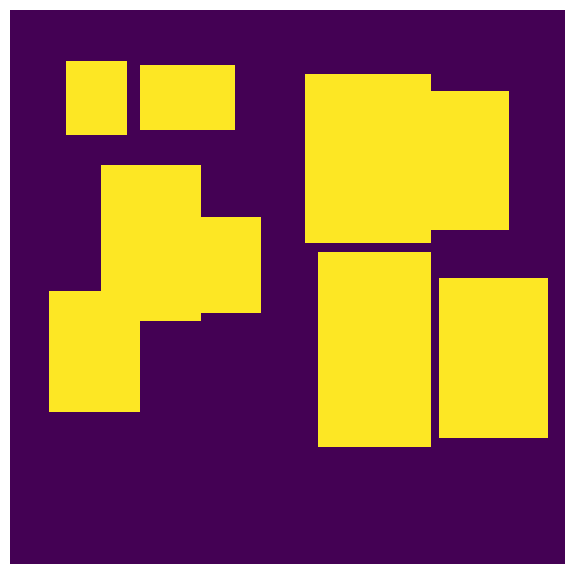

In [10]:
n = 32
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(y[n])

In [11]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing

model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(128, 128, 3))



Segmentation Models: using `keras` framework.


In [12]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [13]:
adam = Adam(lr = 1e-5, beta_1 = 0.9, beta_2 = 0.99, epsilon = None, decay = 0.0)

stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, mode = 'min')

model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])


c:\Users\KENIL\anaconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)

model.fit(
    x=X_train,
    y=Y_train,
    batch_size=1,    
    epochs=25, 
    callbacks=[stop, reduce_lr]
)

Epoch 1/25
393/393 [==============================] - 48s 102ms/step - loss: 1.5716 - dice_coefficient: 0.3683 - lr: 0.0010
Epoch 2/25
393/393 [==============================] - 39s 99ms/step - loss: 1.3527 - dice_coefficient: 0.4251 - lr: 0.0010
Epoch 3/25
393/393 [==============================] - 28s 72ms/step - loss: 1.2923 - dice_coefficient: 0.4434 - lr: 0.0010
Epoch 4/25
393/393 [==============================] - 31s 80ms/step - loss: 1.1918 - dice_coefficient: 0.4700 - lr: 0.0010
Epoch 5/25
393/393 [==============================] - 32s 82ms/step - loss: 1.1453 - dice_coefficient: 0.4886 - lr: 0.0010
Epoch 6/25
393/393 [==============================] - 30s 76ms/step - loss: 1.0820 - dice_coefficient: 0.5090 - lr: 0.0010
Epoch 7/25
393/393 [==============================] - 24s 62ms/step - loss: 1.0379 - dice_coefficient: 0.5232 - lr: 0.0010
Epoch 8/25
393/393 [==============================] - 28s 71ms/step - loss: 0.9926 - dice_coefficient: 0.5422 - lr: 0.0010
Epoch 9/25
393/

In [15]:
evaluation = model.evaluate(X_train, Y_train)

13/13 [==============================] - 1s 41ms/step - loss: 0.9471 - dice_coefficient: 0.5752


In [16]:
print("Train loss: ", evaluation[0])
print("Train accuracy: ", evaluation[1])

Train loss:  0.9470860362052917
Train accuracy:  0.5751896500587463


In [17]:
y_pred = model.predict(X_train)

13/13 [==============================] - 1s 32ms/step


In [18]:
y_pred[0].shape

(128, 128, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


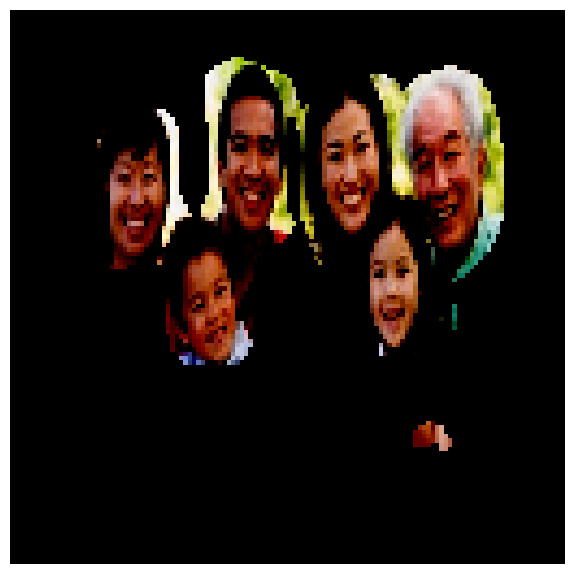

In [19]:
# For a sample image
n = 3
image = cv2.resize(X_train[n], dsize = (im_height, im_width), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0 * (y_pred[n] > 0.1), (im_width, im_height))

image2 = image
image2[:, :, 0] = pred_mask * image[:, :, 0]
image2[:, :, 1] = pred_mask * image[:, :, 1]
image2[:, :, 2] = pred_mask * image[:, :, 2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

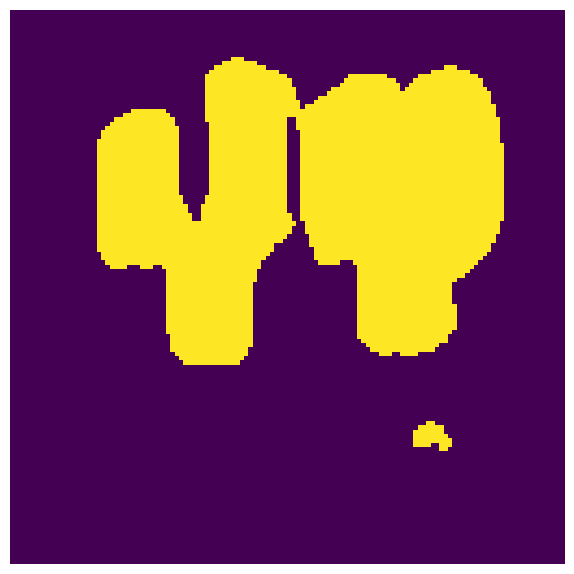

In [20]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)